In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score,cross_validate, RandomizedSearchCV, train_test_split
import optuna
import xgboost as xgb
from sklearn.metrics import r2_score 
import joblib

In [8]:
df2 = pd.read_excel("../markaFile/BMW.xlsx",sheet_name="Sheet1")

In [9]:
df2.drop("Unnamed: 0",axis=1, inplace=True)

In [10]:
df2.head()

,Fiyat,Yıl,Motor Gücü,Motor Hacmi,Kilometre,Boya,Değişen,Seri_1 Serisi,Seri_2 Serisi,Seri_3 Serisi,...,Model_Z4 3.0,Model_Z4 3.0i sDrive,Model_Z4 3.5i sDrive,Model_Z4 M,Yakıt Tipi_Benzin,Yakıt Tipi_Dizel,Yakıt Tipi_LPG & Benzin,Vites Tipi_Düz,Vites Tipi_Otomatik,Vites Tipi_Yarı Otomatik
0,1875000,0.909091,1.888889,0.177885,-1.161049,1.0,2.0,0,0,1,...,0,0,0,0,1,0,0,0,1,0
1,1650000,0.636364,2.444444,2.091346,-0.876404,0.0,0.0,0,0,1,...,0,0,0,0,0,1,0,0,1,0
2,875000,0.000000,2.083333,2.091346,0.404494,1.0,0.0,0,0,1,...,0,0,0,0,0,1,0,0,1,0
3,1340000,0.363636,2.055556,-0.764423,-0.601124,4.0,0.0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
4,495000,-0.090909,2.083333,2.091346,0.471910,8.0,0.0,0,0,1,...,0,0,0,0,0,1,0,0,1,0


In [11]:
y = df2["Fiyat"]
X = df2.drop(["Fiyat"], axis=1)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [13]:
def set_model(model_list, X_train, X_test, y_train, y_test):
    dataf = pd.DataFrame()

    for i in range(len(model_list)):
        algo_name = model_list[i][0]
        algo = model_list[i][1]

        model = algo.fit(X_train, y_train)

        cv_result = cross_val_score(model,
                                    X_train, y_train,
                                    cv=5,
                                    scoring="neg_mean_squared_error")

        y_pred = model.predict(X_test)
        rmse = np.mean(np.sqrt(-cv_result))
        data_list = {"Model": algo_name,
                     "TestDeger": rmse,
                     "MSE":mean_squared_error(y_test, y_pred),
                     "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
                     "MAE": mean_absolute_error(y_test, y_pred)}
        dataf = dataf.append(data_list, ignore_index=True)

    return dataf

In [14]:
models = []
#models.append(('Gradient Boosting Regressor', GradientBoostingRegressor()))
models.append(('XGBModel', XGBRegressor(objective="reg:squarederror",use_label_encoder=False)))
#models.append(('LGBMModel', LGBMRegressor(use_missing=False)))
#models.append(('LRModel', LinearRegression()))
#models.append(('RFModel', RandomForestRegressor()))

In [15]:
df2_model = set_model(models, X_train, X_test, y_train, y_test)
df2_model

C:\Users\senab\AppData\Local\Temp\ipykernel_9980\3059390516.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataf = dataf.append(data_list, ignore_index=True)


,Model,TestDeger,MSE,RMSE,MAE
0,XGBModel,283876.521812,5.566385e+10,235931.876184,108943.810759


In [16]:
def objective(n_trials):
  params = {
        'colsample_bytree': n_trials.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': n_trials.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        "learning_rate": n_trials.suggest_float("learning_rate", 1e-4, 0.5, log=True),
        'n_estimators': [10000],
        "max_depth": n_trials.suggest_int("max_depth", 3, 15),
        'min_child_weight': n_trials.suggest_int('min_child_weight', 1, 300),
    }
  dtrain = xgb.DMatrix(data = X_train, label = y_train)
  dval = xgb.DMatrix(data = X_test, label = y_test)

  regressor = xgb.train(params, dtrain) 
  y_pred = regressor.predict(dval)
  rmse = mean_squared_error(y_test, y_pred, squared=False)

  return rmse

In [17]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=250, n_jobs=-1)

[I 2023-05-23 20:39:31,245] A new study created in memory with name: no-name-5d66ae41-1ef6-4523-90df-8d3ba3a608b5
[I 2023-05-23 20:39:31,630] Trial 0 finished with value: 1271974.0873541827 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.4, 'learning_rate': 0.004536686764559873, 'max_depth': 9, 'min_child_weight': 257}. Best is trial 0 with value: 1271974.0873541827.
[I 2023-05-23 20:39:31,678] Trial 1 finished with value: 1257039.1233497884 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.00611691508221776, 'max_depth': 8, 'min_child_weight': 241}. Best is trial 1 with value: 1257039.1233497884.
[I 2023-05-23 20:39:31,716] Trial 4 finished with value: 1312761.8097411639 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.0003125994990453358, 'max_depth': 14, 'min_child_weight': 179}. Best is trial 1 with value: 1257039.1233497884.
[I 2023-05-23 20:39:31,794] Trial 7 finished with value: 546087.3111729558 and parameters:

[I 2023-05-23 20:39:34,120] Trial 30 finished with value: 838564.0624961203 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.05890786830212408, 'max_depth': 13, 'min_child_weight': 41}. Best is trial 21 with value: 276863.81833727565.
[I 2023-05-23 20:39:34,121] Trial 32 finished with value: 946502.7011922862 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.04220768984209675, 'max_depth': 13, 'min_child_weight': 42}. Best is trial 21 with value: 276863.81833727565.
[I 2023-05-23 20:39:34,193] Trial 31 finished with value: 807957.0166411003 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.06487838947975354, 'max_depth': 13, 'min_child_weight': 43}. Best is trial 21 with value: 276863.81833727565.
[I 2023-05-23 20:39:34,270] Trial 33 finished with value: 896189.763861017 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.05910866566155787, 'max_depth': 13, 'min_child_weig

[I 2023-05-23 20:39:37,047] Trial 60 finished with value: 309626.1258770932 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.33524844574401663, 'max_depth': 4, 'min_child_weight': 13}. Best is trial 44 with value: 254633.5090111538.
[I 2023-05-23 20:39:37,133] Trial 61 finished with value: 363085.90983611974 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.4978412772279552, 'max_depth': 4, 'min_child_weight': 34}. Best is trial 44 with value: 254633.5090111538.
[I 2023-05-23 20:39:37,201] Trial 63 finished with value: 314467.3960297887 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.30826722578820853, 'max_depth': 4, 'min_child_weight': 13}. Best is trial 44 with value: 254633.5090111538.
[I 2023-05-23 20:39:37,243] Trial 62 finished with value: 305694.1184149318 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.4898658570277554, 'max_depth': 4, 'min_child_weight': 14

[I 2023-05-23 20:39:39,782] Trial 90 finished with value: 352377.1007220671 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.2667495921918045, 'max_depth': 14, 'min_child_weight': 40}. Best is trial 44 with value: 254633.5090111538.
[I 2023-05-23 20:39:39,952] Trial 91 finished with value: 249696.22011484596 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.2702250849491784, 'max_depth': 14, 'min_child_weight': 9}. Best is trial 91 with value: 249696.22011484596.
[I 2023-05-23 20:39:40,085] Trial 92 finished with value: 317035.35371833167 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.4045014512047051, 'max_depth': 15, 'min_child_weight': 26}. Best is trial 91 with value: 249696.22011484596.
[I 2023-05-23 20:39:40,245] Trial 93 finished with value: 351407.8539797584 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.3941922049577785, 'max_depth': 14, 'min_child_weight'

[I 2023-05-23 20:39:42,881] Trial 123 finished with value: 590705.7358259092 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.1366958627592931, 'max_depth': 13, 'min_child_weight': 240}. Best is trial 101 with value: 241047.0204013397.
[I 2023-05-23 20:39:42,902] Trial 121 finished with value: 270179.820443844 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.30122296721253417, 'max_depth': 13, 'min_child_weight': 16}. Best is trial 101 with value: 241047.0204013397.
[I 2023-05-23 20:39:42,952] Trial 120 finished with value: 226142.56523579042 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.31168542854514303, 'max_depth': 13, 'min_child_weight': 1}. Best is trial 120 with value: 226142.56523579042.
[I 2023-05-23 20:39:43,113] Trial 122 finished with value: 434414.47629392386 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.12697752191367623, 'max_depth': 13, 'min_chil

[I 2023-05-23 20:39:46,084] Trial 149 finished with value: 243793.25122634976 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.4934196606363178, 'max_depth': 15, 'min_child_weight': 11}. Best is trial 120 with value: 226142.56523579042.
[I 2023-05-23 20:39:46,173] Trial 151 finished with value: 234349.339515865 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.4735986509433003, 'max_depth': 15, 'min_child_weight': 11}. Best is trial 120 with value: 226142.56523579042.
[I 2023-05-23 20:39:46,219] Trial 152 finished with value: 200700.72959726895 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.48262441026411135, 'max_depth': 15, 'min_child_weight': 10}. Best is trial 152 with value: 200700.72959726895.
[I 2023-05-23 20:39:46,230] Trial 153 finished with value: 231420.22313925688 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.3591285929896135, 'max_depth': 15, 'min_chi

[I 2023-05-23 20:39:49,560] Trial 179 finished with value: 260878.97150128701 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.4948963126642918, 'max_depth': 15, 'min_child_weight': 7}. Best is trial 152 with value: 200700.72959726895.
[I 2023-05-23 20:39:49,594] Trial 183 finished with value: 265886.3999495509 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.4915699518691043, 'max_depth': 15, 'min_child_weight': 6}. Best is trial 152 with value: 200700.72959726895.
[I 2023-05-23 20:39:49,628] Trial 184 finished with value: 241924.94669421992 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.4988674768942035, 'max_depth': 15, 'min_child_weight': 8}. Best is trial 152 with value: 200700.72959726895.
[I 2023-05-23 20:39:49,629] Trial 182 finished with value: 248584.06426529016 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.4938371671780857, 'max_depth': 15, 'min_child_

[I 2023-05-23 20:39:52,888] Trial 212 finished with value: 1223176.3781191157 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.00815950673396243, 'max_depth': 14, 'min_child_weight': 11}. Best is trial 152 with value: 200700.72959726895.
[I 2023-05-23 20:39:52,903] Trial 209 finished with value: 1301941.345404766 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.0011950286121216582, 'max_depth': 14, 'min_child_weight': 9}. Best is trial 152 with value: 200700.72959726895.
[I 2023-05-23 20:39:52,999] Trial 211 finished with value: 1276478.7765765805 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.003403311176649585, 'max_depth': 14, 'min_child_weight': 11}. Best is trial 152 with value: 200700.72959726895.
[I 2023-05-23 20:39:53,047] Trial 213 finished with value: 1257420.8724548917 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.005077536574305003, 'max_depth': 14, '

[I 2023-05-23 20:39:56,216] Trial 238 finished with value: 282929.36388976703 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.36026527572906897, 'max_depth': 15, 'min_child_weight': 18}. Best is trial 152 with value: 200700.72959726895.
[I 2023-05-23 20:39:56,285] Trial 239 finished with value: 285032.9399580545 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.3680540092001694, 'max_depth': 15, 'min_child_weight': 18}. Best is trial 152 with value: 200700.72959726895.
[I 2023-05-23 20:39:56,321] Trial 241 finished with value: 285661.9787899666 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.3674593726337774, 'max_depth': 15, 'min_child_weight': 18}. Best is trial 152 with value: 200700.72959726895.
[I 2023-05-23 20:39:56,338] Trial 240 finished with value: 282892.56763650436 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.36049997493906627, 'max_depth': 15, 'min_ch

In [18]:
print(f"Optimized RMSE: {study.best_value:.4f}")
print("Best params:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")

Optimized RMSE: 200700.7296
Best params:
	colsample_bytree: 1.0
	subsample: 0.6
	learning_rate: 0.48262441026411135
	max_depth: 15
	min_child_weight: 10


In [19]:
model = XGBRegressor(objective="reg:squarederror",use_label_encoder=False)
grid_params = {"learning_rate": [0.1, 0.4],
                  "max_depth": [13,15,17],
                  "n_estimators": [500,750,1000],
               'colsample_bytree': [0.6],
               'subsample': [1],
               'min_child_weight': [10]
              }

grid_model = GridSearchCV(estimator=model,
                                  param_grid=grid_params,
                                  cv=3,
                                  verbose=True,
                                  n_jobs=1).fit(X_train,y_train)


grid_final_model = model.set_params(**grid_model.best_params_).fit(X_train,y_train)
    
cv_results = cross_validate(grid_final_model,
                            X_train, y_train,
                            cv=5,
                            scoring="neg_mean_squared_error")
print("BEST PARAMS: ", grid_model.best_params_)
    
y_pred = grid_final_model.predict(X_test)

rmse = (np.sqrt(-cv_results['test_score'])).mean()
data_list = {"TestDeger": rmse,
             "MSE":mean_squared_error(y_test, y_pred),
             "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
             "MAE": mean_absolute_error(y_test, y_pred)}

print(data_list)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
BEST PARAMS:  {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 17, 'min_child_weight': 10, 'n_estimators': 500, 'subsample': 1}
{'TestDeger': 329359.47394237074, 'MSE': 58505150823.40929, 'RMSE': 241878.38023149007, 'MAE': 123361.97440890763}


In [20]:
r2 = r2_score(y_test, y_pred)
r2

0.9089649306034677

In [21]:
n= len(X_train)
p =len(X.columns)
adj_R2 = 1- ((1-r2) * (n-1)/(n-p-1))
adj_R2

0.8849930865539433

In [22]:
marka_model = joblib.dump(grid_final_model, "BMW.pkl")

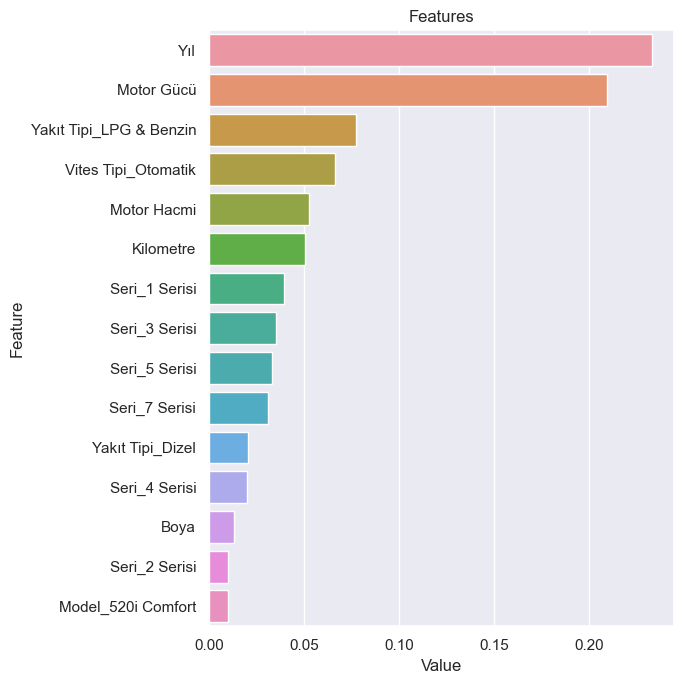

In [23]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(7, 7))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:15])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")
plot_importance(grid_final_model,X)